In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, Dropout, TimeDistributed
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

Mount personal Google Drive folder

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


1. Download the dataset from [here](https://www.kaggle.com/datasets/henryhan117/sp-500-historical-data/data)

2. Put the dataset into personal google drive folder
3. Read the dataset from Google Drive Folder

<Axes: xlabel='Date'>

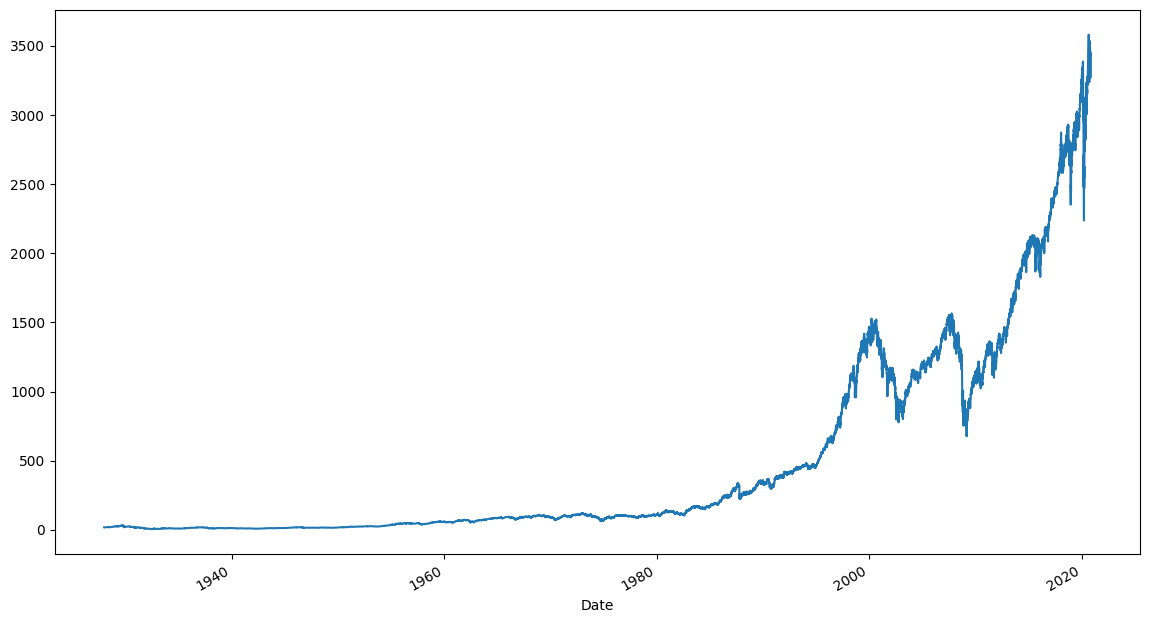

In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/Links Accademy - AI/2. Time series analysis/data/sp500-spx_full.csv', parse_dates=['Date'], index_col='Date')
df['Close'].plot(figsize=(14,8))

Do some EDA tasks: like info, describe...

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23323 entries, 1927-12-30 to 2020-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       23323 non-null  float64
 1   High       23323 non-null  float64
 2   Low        23323 non-null  float64
 3   Close      23323 non-null  float64
 4   Adj Close  23323 non-null  float64
 5   Volume     23323 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.2 MB


In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,23323.000000,23323.000000,23323.000000,23323.000000,23323.000000,2.332300e+04
mean,486.821737,489.690119,483.762812,486.918598,486.918598,7.691668e+08
std,726.187716,730.112168,721.890344,726.278798,726.278798,1.484864e+09
min,4.400000,4.400000,4.400000,4.400000,4.400000,0.000000e+00
25%,23.855001,23.855001,23.855001,23.855001,23.855001,1.280000e+06
50%,99.500000,100.309998,98.720001,99.500000,99.500000,1.734000e+07
75%,834.035004,843.744995,822.889984,834.704987,834.704987,5.378550e+08
max,3564.739990,3588.110107,3535.229980,3580.840088,3580.840088,1.145623e+10


Only considers data from 2004-01-01 onwards

In [7]:
df = df.loc['2004-01-01':]
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,1111.920044,1118.849976,1105.079956,1108.479980,1108.479980,1153200000
2004-01-05,1108.479980,1122.219971,1108.479980,1122.219971,1122.219971,1578200000
2004-01-06,1122.219971,1124.459961,1118.439941,1123.670044,1123.670044,1494500000
2004-01-07,1123.670044,1126.329956,1116.449951,1126.329956,1126.329956,1704900000
2004-01-08,1126.329956,1131.920044,1124.910034,1131.920044,1131.920044,1868400000
...,...,...,...,...,...,...
2020-10-29,3277.169922,3341.050049,3259.820068,3310.110107,3310.110107,4903070000
2020-10-30,3293.590088,3304.929932,3233.939941,3269.959961,3269.959961,4840450000
2020-11-02,3296.199951,3330.139893,3279.739990,3310.239990,3310.239990,4310590000


Only consider 'Close' column

In [8]:
feature_to_analyze = ['Close']

Our goal is to find anomalies on the entire dataset, for this reason (in addition to the fact of not having labels) we can also not use a test set.
Anyway, we can use scikit learn's train test split to create two arrays containing test data and train data or create just an array with shape (x, 1).

In [9]:
train_data, test_data = train_test_split(df[feature_to_analyze], train_size=0.98, shuffle=False)
train_data.sort_index(inplace=True)
test_data.sort_index(inplace=True)
train_data.shape, test_data.shape

((4156, 1), (85, 1))

Plot train data

<Axes: xlabel='Date'>

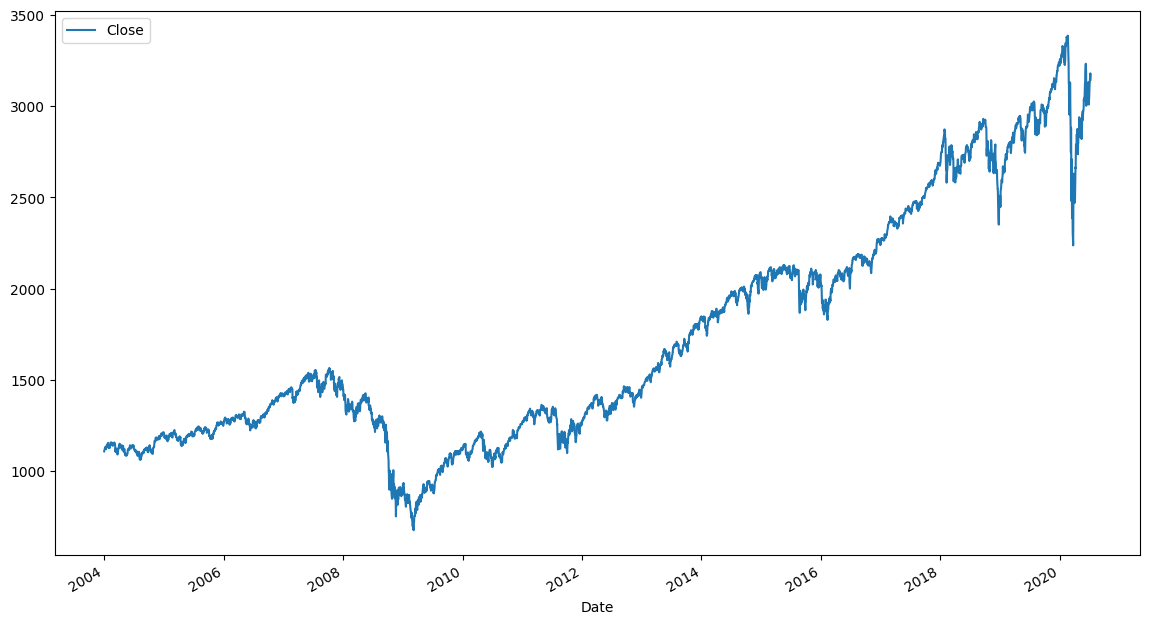

In [10]:
train_data.plot(figsize=(14,8))

Plot test data (if available)

<Axes: xlabel='Date'>

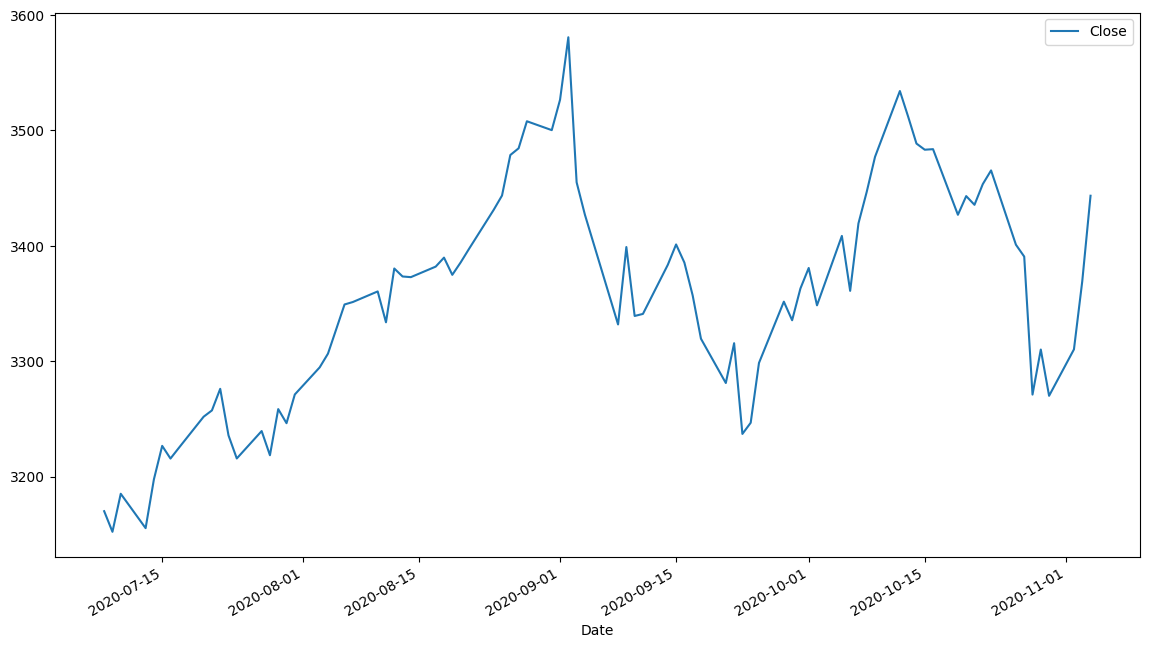

In [11]:
test_data.plot(figsize=(14,8))

Create two methods:

- The method getScaledData takes as input two DataFrames (train_df and test_df) and returns scaled versions of these DataFrames using different scaling methods (standard or minmax).

- createDataset: given a DataFrame df and certain parameters, it creates input-output pairs. It return two dataframes:
  - the first one (sliding windows approach) with shape (train_shape - lookback, lookback, 1)
  - second one with shape (train_shape,)

In [12]:
def getScaledData(method='standard', train_df=None, test_df=None, feature_col='feature'):
    if method == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler = scaler.fit(train_df[[feature_col]])
    train_df['scaled_'+feature_col] = scaler.transform(train_df[[feature_col]])
    test_df['scaled_'+feature_col] = scaler.transform(test_df[[feature_col]])
    return train_df, test_df, scaler

def createDataset(df, lookback=30, feature_col=None):
    data_x, data_y = [], []
    for i in range(lookback, len(df)):
        data_x.append(df.iloc[i-lookback:i][[feature_col]].values)
        data_y.append(df.iloc[i][feature_col])
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    return data_x, data_y

Calling "getScaledData" standardize train and test

In [13]:
train_df, test_df, scaler = getScaledData('standard', train_data, test_data, 'Close')
train_df.shape, test_df.shape, train_data.shape

((4156, 2), (85, 2), (4156, 2))

Plot scaled data

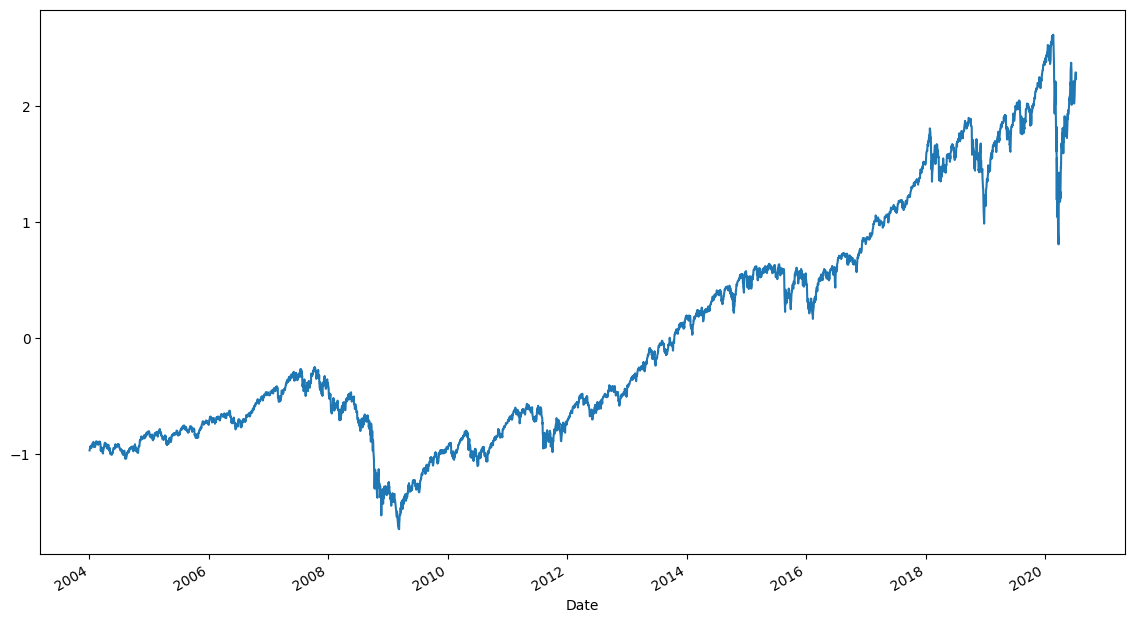

In [14]:
train_df['scaled_Close'].plot(figsize=(14,8))
plt.show()

Using 30 as timestep (sliding windows lenght), call "createDataset" method and create train_x with sliding windows and labels in train_y

In [15]:
TIMESTEPS = 30

train_x, train_y = createDataset(train_df, TIMESTEPS, 'scaled_Close')
test_x, test_y = createDataset(test_df, TIMESTEPS, 'scaled_Close')

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((4126, 30, 1), (4126,), (55, 30, 1), (55,))

## Autoencoder LSTM model

Let's create our neural network model using keras:

**Encoder**
- LSTM layer
- Dropout layer: to potentially avoid overfitting
- RepeatVector: to implement full connected layers

**Decoder** : LSTM layer, dropout and

TimeDistributed(Dense) layer: takes the output of the Dense layer and applies it independently to each time step of the input sequence.

In [16]:
LSTM_units = 64
model = keras.Sequential()
model.add(LSTM(LSTM_units, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=False,name='encoder_lstm'
              ))
model.add(Dropout(0.2, name='encoder_dropout'))
model.add(RepeatVector(train_x.shape[1], name='decoder_repeater'))
model.add(LSTM(LSTM_units, return_sequences=True, name='decoder_lstm'))
model.add(Dropout(rate=0.2, name='decoder_dropout'))
model.add(TimeDistributed(Dense(train_x.shape[2],name='decoder_dense_output')))

model.compile(loss='mae', optimizer='adam')

Print model summary

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_lstm (LSTM)         (None, 64)                16896     
                                                                 
 encoder_dropout (Dropout)   (None, 64)                0         
                                                                 
 decoder_repeater (RepeatVe  (None, 30, 64)            0         
 ctor)                                                           
                                                                 
 decoder_lstm (LSTM)         (None, 30, 64)            33024     
                                                                 
 decoder_dropout (Dropout)   (None, 30, 64)            0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             65        
 ributed)                                               

Train our model considering autoencoder (test set not mandatory) and timeseries (temporal dependencies) concepts

In [18]:
%time history = model.fit(train_x, train_x, epochs=10, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/10
117/117 [==============================] - 11s 57ms/step - loss: 0.1823 - val_loss: 0.2527
Epoch 2/10
117/117 [==============================] - 4s 34ms/step - loss: 0.1431 - val_loss: 0.2026
Epoch 3/10
117/117 [==============================] - 4s 37ms/step - loss: 0.1006 - val_loss: 0.1974
Epoch 4/10
117/117 [==============================] - 6s 47ms/step - loss: 0.1051 - val_loss: 0.1793
Epoch 5/10
117/117 [==============================] - 4s 34ms/step - loss: 0.1204 - val_loss: 0.1766
Epoch 6/10
117/117 [==============================] - 4s 35ms/step - loss: 0.1286 - val_loss: 0.2472
Epoch 7/10
117/117 [==============================] - 6s 50ms/step - loss: 0.1014 - val_loss: 0.1874
Epoch 8/10
117/117 [==============================] - 4s 33ms/step - loss: 0.1095 - val_loss: 0.1746
Epoch 9/10
117/117 [==============================] - 4s 33ms/step - loss: 0.1019 - val_loss: 0.1653
Epoch 10/10
117/117 [==============================] - 6s 50ms/step - loss: 0.1003 - val_l

Using history from model.fit() check possible overfitting by plotting training and validation loss.

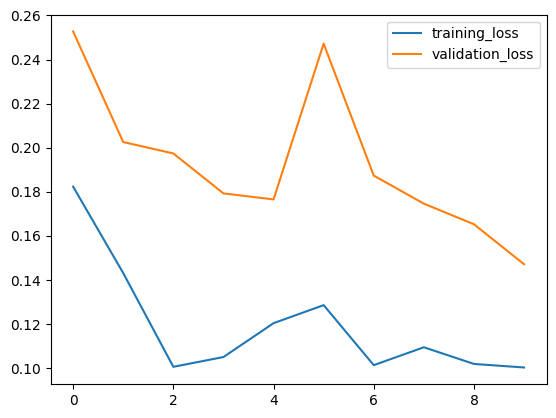

In [19]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

Reconstruct the starting dataset using the LSTM autoencoder model

In [20]:
reconstructed = model.predict(train_x)
reconstructed.shape, train_x.shape

129/129 [==============================] - 3s 15ms/step


((4126, 30, 1), (4126, 30, 1))

Calculate mean absolute errors between recostructed data and real data

In [21]:
mae_loss = np.mean(np.abs(reconstructed - train_x), axis=1)
mae_loss

array([[0.20934249],
       [0.21068309],
       [0.20960149],
       ...,
       [0.09711124],
       [0.09118232],
       [0.08865054]])

Using seaborn plot distribution loss (histgram plot) of errors

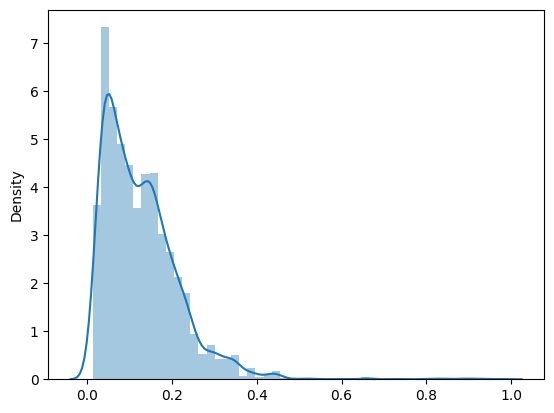

In [22]:
sns.distplot(mae_loss[:,0])
plt.show()

Calculate a threshold based on mean and standard deviation of errors

In [23]:
mean = np.mean(mae_loss)
std = np.std(mae_loss)
num_std = 1

ae_threshold = mean + num_std * std
ae_threshold

0.2173142161965461

In the same axis, plot the real data, recostructed data, mean absolute error of predictions and related threshold

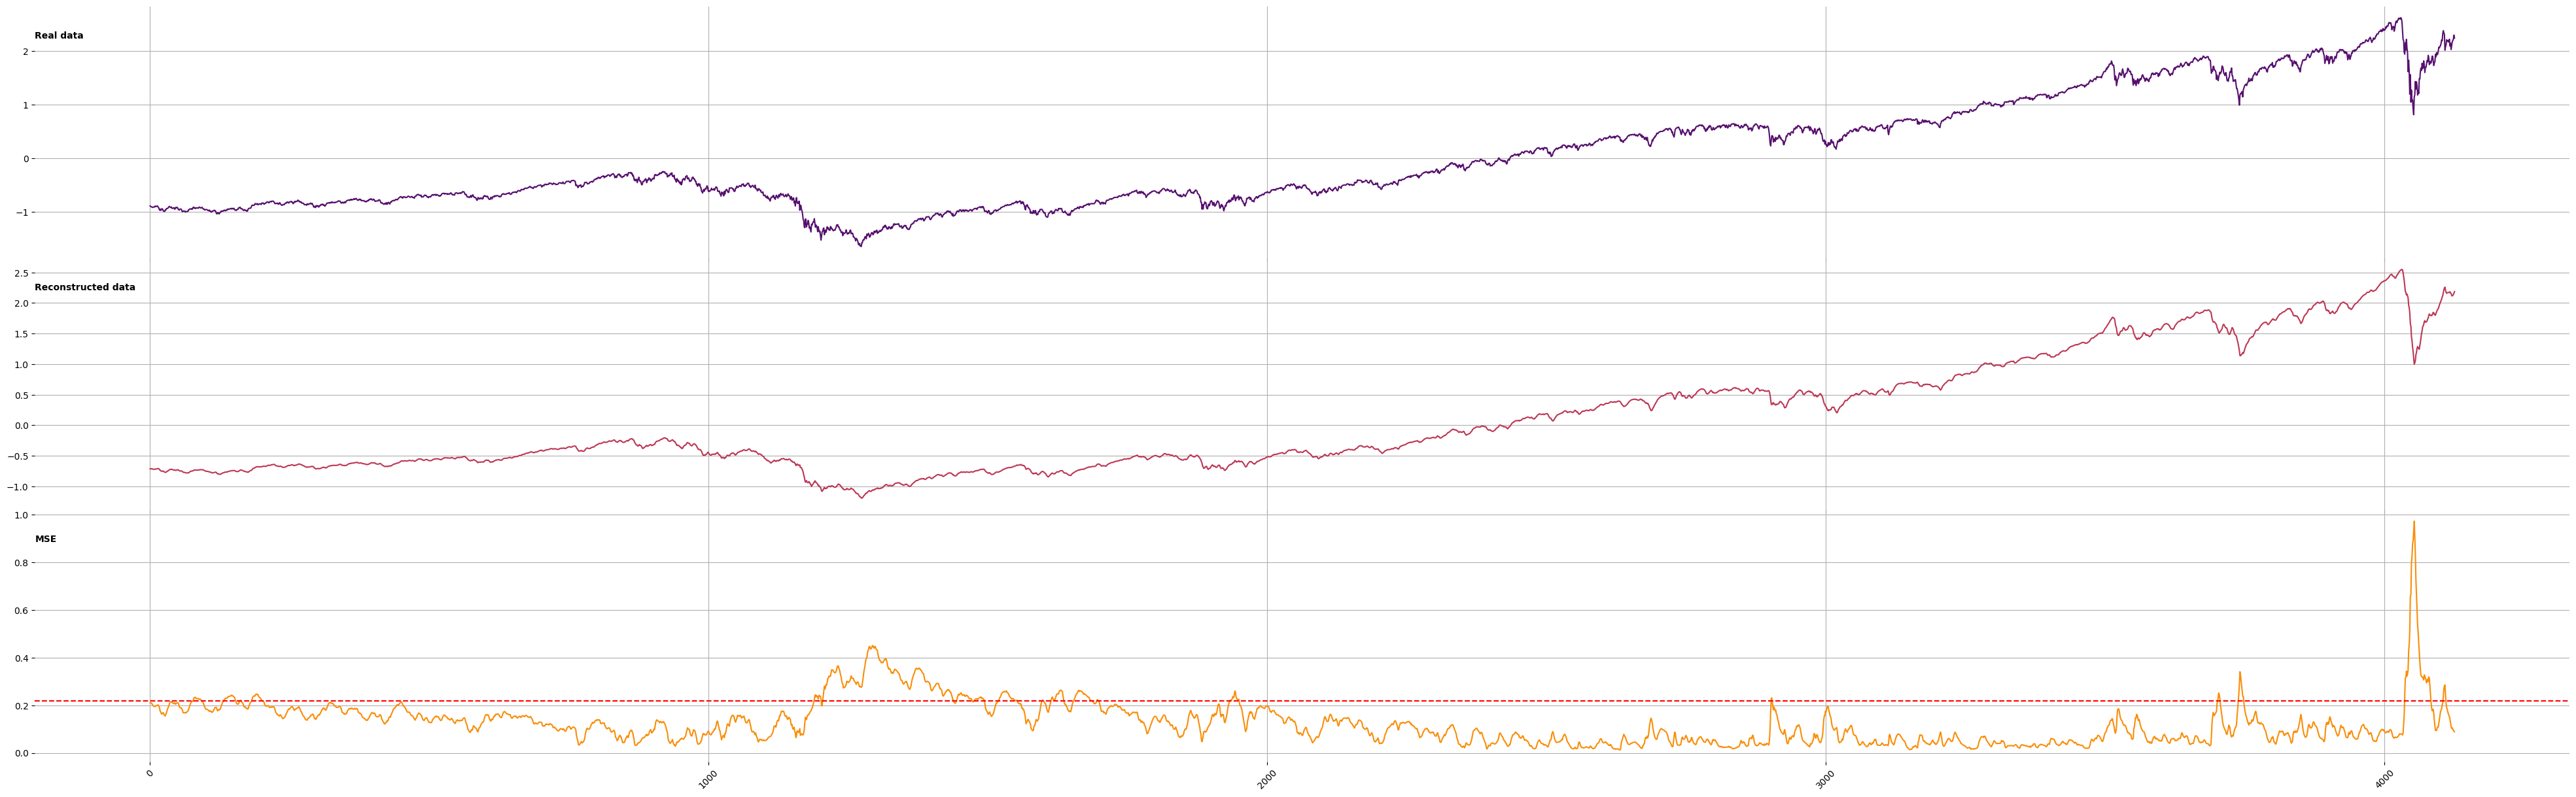

In [24]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (50, 15)

fig, ax = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=False))
plt.subplots_adjust(hspace=.0)

palette = sns.color_palette("inferno", 3).as_hex()
x = range(train_y.shape[0])

ax[0].grid()
ax[0].plot(train_y, label='Real data', color = palette[0])
ax[0].set_title('Real data', fontdict={'fontsize': 10, 'fontweight': 'bold'}, y=+0.85, loc='left')

ax[1].grid()
ax[1].plot(reconstructed[:, -1, -1], label='Reconstructed data', color = palette[1])
ax[1].set_title('Reconstructed data', fontdict={'fontsize': 10, 'fontweight': 'bold'}, y=+0.85, loc='left')

ax[2].grid()
ax[2].plot(x, mae_loss, label='MSE', color = palette[2])
plt.axhline(y=ae_threshold, color='r', linestyle='--', label='Threshold')
ax[2].set_title('MSE', fontdict={'fontsize': 10, 'fontweight': 'bold'}, y=+0.85, loc='left')

ax[2].tick_params(axis='x', rotation=45)

Calculate anomalies index and anomalies values using MAE, threshold and real data

In [25]:
anomalies_index = np.where(mae_loss > ae_threshold)
anomalies_values = pd.DataFrame(train_y)[mae_loss > ae_threshold]

In the same scatter plot, visualize real normal data point in blue and real anomaly data point in red

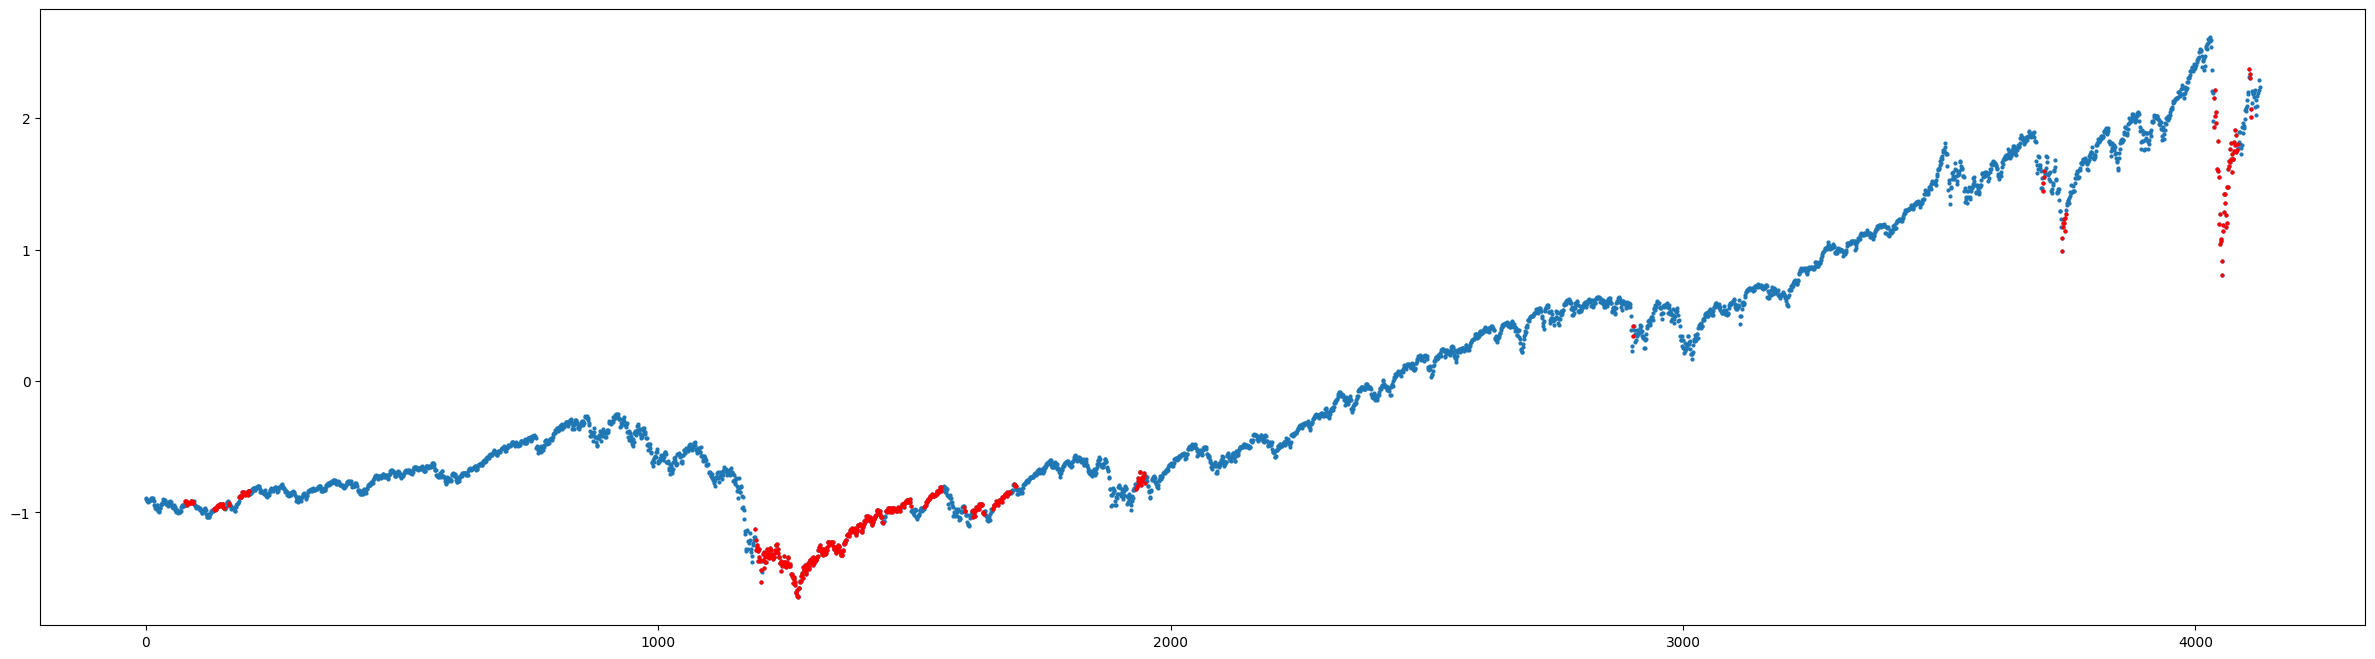

In [26]:
matplotlib.rcParams['figure.figsize'] = (30, 8)

plt.scatter(range(train_y.shape[0]), train_y, s = 4)
plt.scatter(anomalies_index[0], anomalies_values, color='r', s = 4)
plt.show()